## Installing the PyPDF2 package for PDF processing


In [4]:
!pip install PyPDF2;
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 162.5 kB/s eta 0:01:19
     --------------------------------------- 0.0/12.8 MB 217.9 kB/s eta 0:00:59
     --------------------------------------- 0.1/12.8 MB 297.7 kB/s eta 0:00:43
     --------------------------------------- 0.1/12.8 MB 302.7 kB/s eta 0:00:43
     --------------------------------------- 0.1/12.8 MB 500.5 kB/s eta 0:00:26
      -------------------------------------- 0.2/12.8 MB 655.1 kB/s eta 0:00:20
     - -------------------------------------- 0.4/12.8 MB 1.0 MB/s eta 0:00:13
     - -------------------------------------- 0.5/12.8 MB 1.3 MB/s eta 0:00:10
     -- ------------------------------------- 0.9/12.8 MB 2.1 MB/s eta 0:00:06
     --- ------------------------------------ 1.1/12.8 MB 2.2 MB/s 

## necessary libraries

In [5]:
import spacy
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from collections import Counter
from gensim.models.phrases import Phrases, Phraser
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
import PyPDF2
nlp = spacy.load("en_core_web_sm")

# extracting text from pdf file

In [51]:
def extract_text_from_pdf(pdf_file_path):
    text = ""
    with open(pdf_file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        for page in reader.pages:
            text += page.extract_text()
    return text
pdf_resume_file = 'Nina Patel.pdf'
resume_text = extract_text_from_pdf(pdf_resume_file)

## Loading Data
* Remove duplicates based on job Title, Description, and Company name to ensure uniqueness of job listings

In [17]:
canada_df = pd.read_csv('Canada_data.csv')
usa_df = pd.read_csv('USA_data.csv')
frames = [canada_df, usa_df]
df = pd.concat(frames,ignore_index=True)

jobs_df = df.copy()
jobs_df = jobs_df.drop_duplicates(subset=['Title','Description','Company'])
jobs_df.head(3)

,Title,Company,Link,Description
0,Studio Support Specialist,Evolution Gaming,https://www.careerjet.ca/jobad/cac6487429f0718...,Company DescriptionEvolution is a market-leadi...
1,Crew leader - Climbing Arborist | Chef d'équip...,Strathmore Facilities Management Inc,https://www.careerjet.ca/jobad/caaec4452e78a2c...,The Arbo crew uses the very best equipment fro...
2,Facility Technician,District of Saanich,https://www.careerjet.ca/jobad/caec5f049d5490f...,Saanich Commonwealth Place is recruiting for a...


* Converts the text to lowercase.
* Removes stopwords, punctuation, URLs, email addresses, and numbers.
* Keeps only tokens that are nouns, verbs, or adjectives.
* Lemmatizes the remaining tokens to get their base forms.

In [18]:
def preprocess_text(text):
    doc = nlp(text.lower())
    processed_text = []

    for token in doc:
        if not token.is_stop and not token.is_punct and not token.like_url and not token.like_email and not token.like_num :
            if token.pos_ in ['NOUN','VERB','ADJ']:
                processed_text.append(token.lemma_)

    return ' '.join(processed_text)





jobs_df['processed_description'] = jobs_df['Description'].apply(preprocess_text)
jobs_df['processed_title'] = jobs_df['Title'].apply(preprocess_text)

###  The below function is called twice to create and display word clouds for the processed job descriptions and titles, providing a visual representation of the most frequent words.

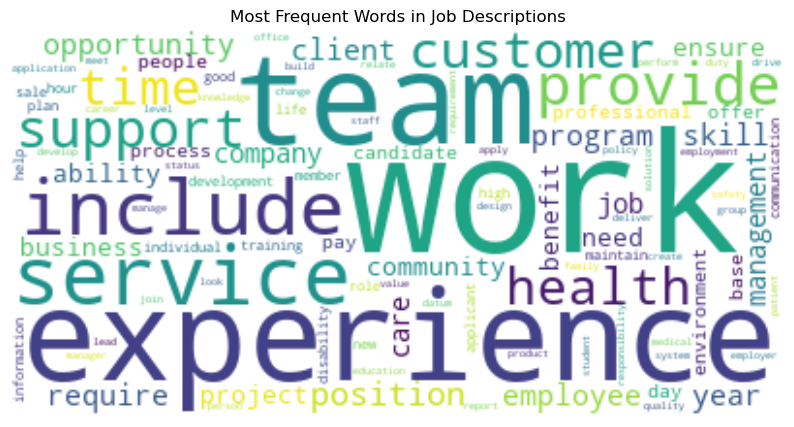

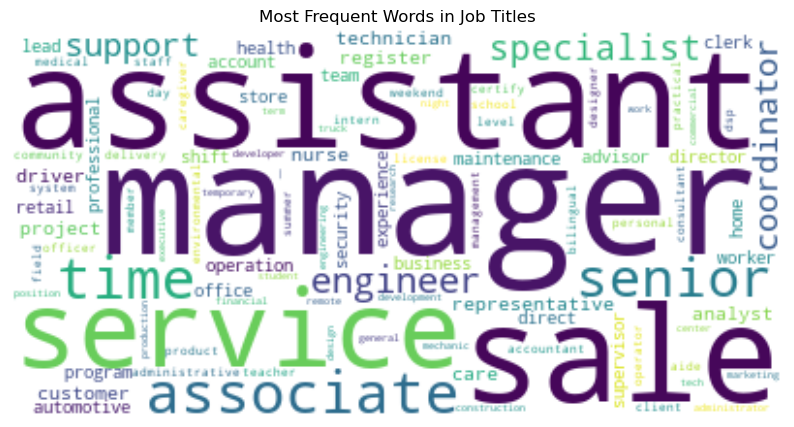

In [19]:
def plot_most_frequent_words(text_data, title, max_words=100):
    all_words = ' '.join(text_data).split()
    word_freq = Counter(all_words)
    most_common_words = dict(word_freq.most_common(max_words))
    wordcloud = WordCloud(background_color='white', max_words=max_words).generate_from_frequencies(most_common_words)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()
    print('')




plot_most_frequent_words(jobs_df['processed_description'], 'Most Frequent Words in Job Descriptions')


plot_most_frequent_words(jobs_df['processed_title'], 'Most Frequent Words in Job Titles')


### The "remove_irrelevant" list contains words that we believe do not contribute meaningful information for job matching or analysis purposes. These words may be too common

In [20]:
remove_irrelevant = ['field','job', 'team', 'work', 'include', 'customer', 'time', 'year', 'opportunity','great','bonus',
                     'require', 'employee', 'skill', 'company', 'ability', 'base', 'pay', 'day', 'ensure', 'job', 'need',
                     'people', 'offer', 'role', 'candidate', 'individual', 'good', 'life', 'hour', 'help', 'new', 'apply',
                     'knowledge', 'look', 'join', 'meet', 'value', 'career', 'level', 'staff', 'family', 'requirement',
                     'perform', 'relate', 'employer', 'change', 'status', 'complete', 'duty', 'able','home','worker',
                     'weekend','global','summer','|']


jobs_df['processed_description'] = jobs_df['processed_description'].apply(lambda x: " ".join(word for word in x.split() if word not in remove_irrelevant))
jobs_df['processed_title'] = jobs_df['processed_title'].apply(lambda x: " ".join(word for word in x.split() if word not in remove_irrelevant))

* Tokenization
* Phrase Modeling
* Word2Vec Training
* Vectorization of Descriptions and Titles
* Combining Vectors

In [21]:
tokenized_descriptions = [description.split() for description in jobs_df['processed_description']]
tokenized_titles = [title.split() for title in jobs_df['processed_title']]

descriptions_phrases = Phrases(tokenized_descriptions, min_count=4, threshold=5)
titles_phrases = Phrases(tokenized_titles, min_count=4, threshold=5)


descriptions_bigram = Phraser(descriptions_phrases)
bigram_descriptions = [descriptions_bigram[sentence] for sentence in tokenized_descriptions]


titles_bigram = Phraser(titles_phrases)
bigram_titles = [titles_bigram[sentence] for sentence in tokenized_titles]




word2vec_description_model = Word2Vec(sentences=bigram_descriptions, vector_size=100 ,window=3, min_count=5, workers=4)
word2vec_title_model = Word2Vec(sentences=bigram_titles, vector_size=100, window=3, min_count=5, workers=4)




def document_vector(word2vec_model, doc):
    doc = [word for word in doc.split() if word in word2vec_model.wv]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model.wv[doc], axis=0)





job_descriptions_vectors = np.array([document_vector(word2vec_description_model, text) for text in jobs_df['processed_description']])

job_titles_vectors = np.array([document_vector(word2vec_title_model, text) for text in jobs_df['processed_title']])

combined_vectors = np.concatenate((job_descriptions_vectors, job_titles_vectors), axis=1)





print('job descriptions vectors:\n ')
print(job_descriptions_vectors[0])
print('\n job titles vectors:\n ')
print(job_titles_vectors[0])

job descriptions vectors:
 
[-0.19258352  0.1726019   0.24064925 -0.02275422  0.17396869 -0.5662075
  0.3748861   0.73719853 -0.3316988  -0.04489843 -0.30732414 -0.75806004
  0.08872636  0.10022674  0.13994372 -0.19640122  0.05637573 -0.38014996
 -0.14810073 -0.7021061   0.11611032  0.2277055   0.30720165 -0.23894662
  0.01632629  0.14395744 -0.4179301   0.0088619  -0.35009065  0.04326877
  0.7623122  -0.16302173 -0.11692919 -0.28493848 -0.01256828  0.28637558
  0.4679217  -0.25883606 -0.36061433 -0.65069705  0.23088112 -0.31566137
 -0.10120883  0.12072947  0.18966451 -0.1415246   0.02256001 -0.11088301
 -0.1069769   0.0250931   0.43241927 -0.7297753  -0.2543222   0.2910225
 -0.49959207  0.23624861  0.25781423 -0.05201842 -0.38199925  0.27682146
  0.20541094  0.08808199  0.28958103 -0.10007309 -0.35252056  0.46966255
  0.12639986  0.39872476 -0.7169399   0.39649206 -0.3279497   0.28844503
  0.70828307 -0.25555855  0.304786   -0.05145458 -0.11987576  0.06695525
 -0.24534754  0.22312573 

### Manual evaluation

In [ ]:
print(word2vec_description_model.wv.most_similar('data'))
print(word2vec_title_model.wv.most_similar('project'))

In [23]:
data_words = [word for sentence in bigram_descriptions for word in sentence if word.startswith('data_')]
project_words = [word for sentence in bigram_descriptions for word in sentence if word.startswith('project_')]
machine_words = [word for sentence in bigram_descriptions for word in sentence if word.startswith('machine_')]


unique_data_words = set(data_words)
unique_project_words = set(project_words)
unique_machine_words = set(machine_words)
print("Unique words starting with 'data_':", unique_data_words,'\n')
print("Unique words starting with 'project_':", unique_project_words,'\n')
print("Unique words starting with 'machine_':", unique_machine_words)

Unique words starting with 'data_': {'data_governance', 'data_analysis', 'data_inform', 'data_set', 'data_drive', 'data_quality', 'data_analytic', 'data_entry'} 

Unique words starting with 'project_': {'project_management', 'project_inception', 'project_initiation', 'project_coordination', 'project_deliverable', 'project_span', 'project_coordinator', 'project_lifecycle', 'project_scope', 'project_commence', 'project_manager', 'project_construct', 'project_attorney', 'project_timeline'} 

Unique words starting with 'machine_': {'machine_learning', 'machine_learn', 'machine_sewing', 'machine_diagnostic', 'machine_operator'}


## Perform K-Means clustering with  different k and plot the inertia values.
## The 'elbow' in the plot helps determine the optimal number of clusters for combined job description and title vectors.


C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

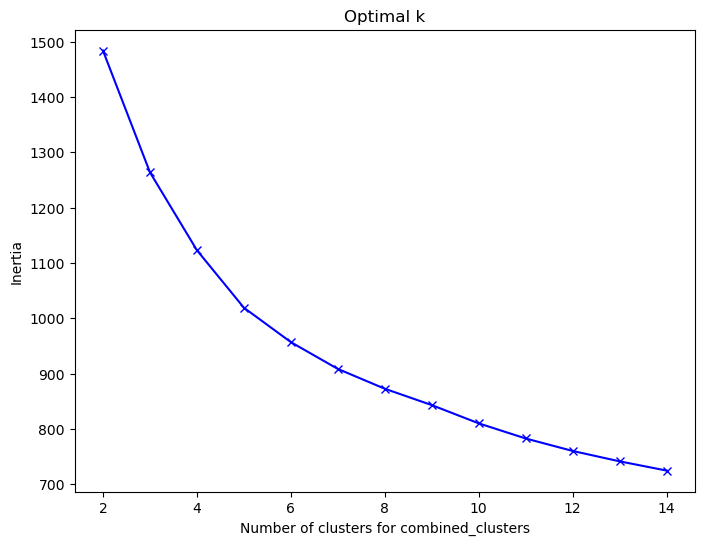

In [28]:
inertia = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_vectors)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters for combined_clusters')
plt.ylabel('Inertia')
plt.title('Optimal k')
plt.show()

## Calculate and print silhouette scores for different k.
## Plot silhouette scores to identify the optimal number of clusters for combined job description and title vectors.


C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=2: 0.22849370239338945


C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=3: 0.19567026592614473


C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=4: 0.18698161920136153


C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=5: 0.17590868534994888


C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=6: 0.16221131432072972


C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=7: 0.1599826230033189


C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=8: 0.158289253868838


C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=9: 0.1468088712650155


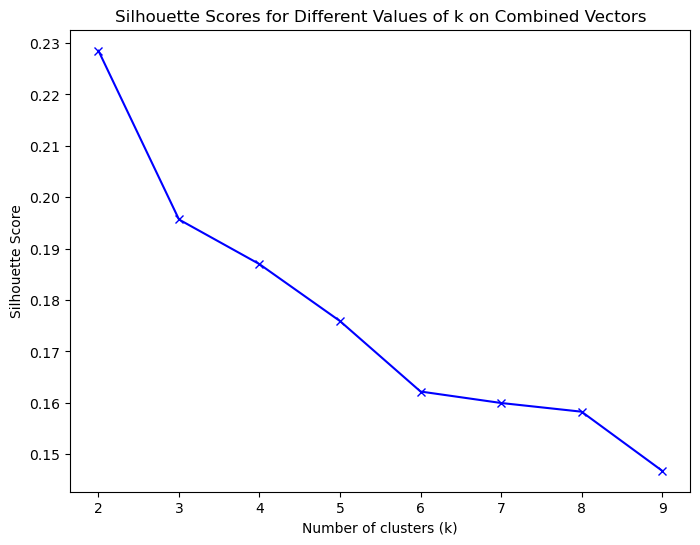

In [29]:
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(combined_vectors)
    silhouette_avg = silhouette_score(combined_vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette Score for k={k}: {silhouette_avg}")


plt.figure(figsize=(8, 6))
plt.plot(K_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Values of k on Combined Vectors')
plt.xticks(K_range)
plt.show()

# K-Means Clustering
## Perform K-Means clustering on combined job description and title vectors with 2 clusters

In [30]:
num_clusters = 2
kmeans_combined = KMeans(n_clusters=num_clusters, random_state=42)
combined_clusters = kmeans_combined.fit_predict(combined_vectors)


silhouette_avg_combined = silhouette_score(combined_vectors, combined_clusters)
print("Combined descriptions and titles silhouette score:", silhouette_avg_combined)


jobs_df['combined_cluster'] = combined_clusters
combined_cluster_labels = kmeans_combined.labels_

C:\Users\zivke\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Combined descriptions and titles silhouette score: 0.22849370239338945


## Reduce the dimensionality of combined job description and title vectors for visualization.

## Create a scatter plot of the t-SNE-transformed data, colored by cluster labels.


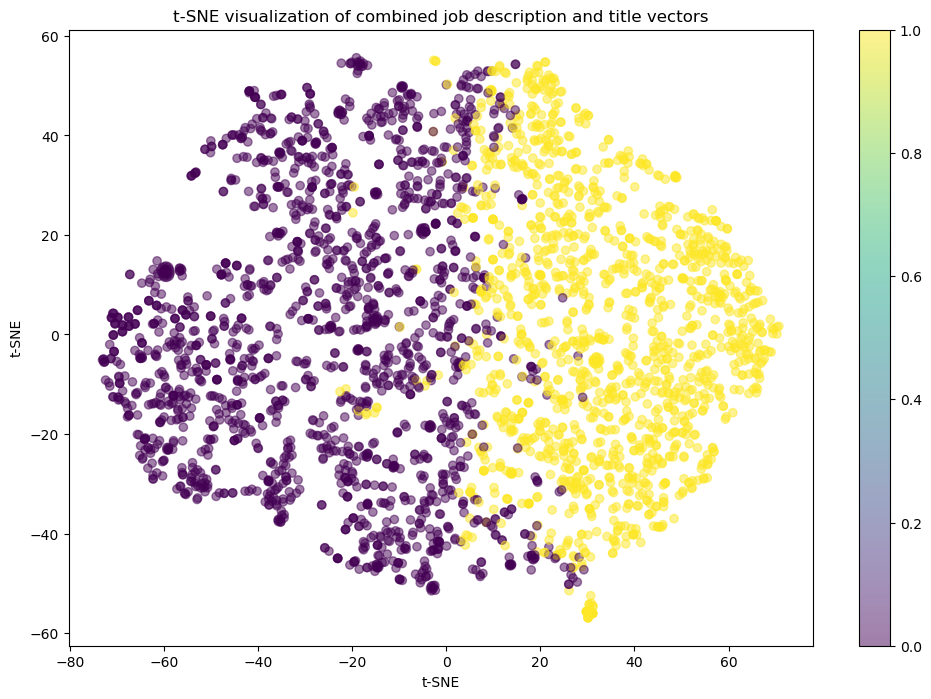

In [32]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(combined_vectors)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=combined_cluster_labels, cmap='viridis', alpha=0.5)
plt.colorbar()

plt.title('t-SNE visualization of combined job description and title vectors')
plt.xlabel('t-SNE' )
plt.ylabel('t-SNE')
plt.show()



## Display word clouds for each cluster of combined job descriptions and titles.


*** Cluster 0 ***



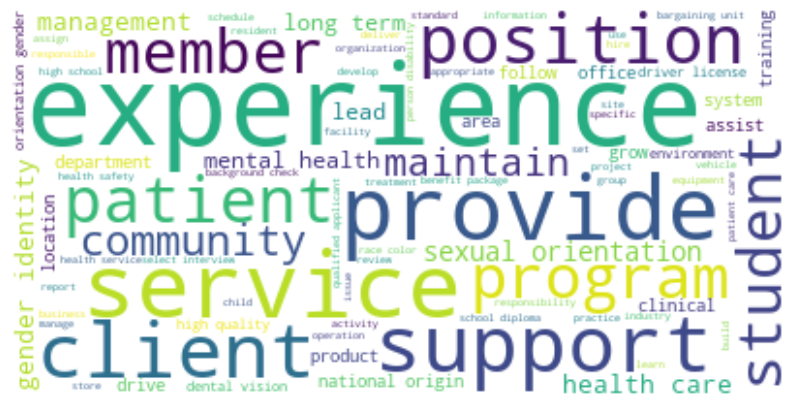


*** Cluster 1 ***



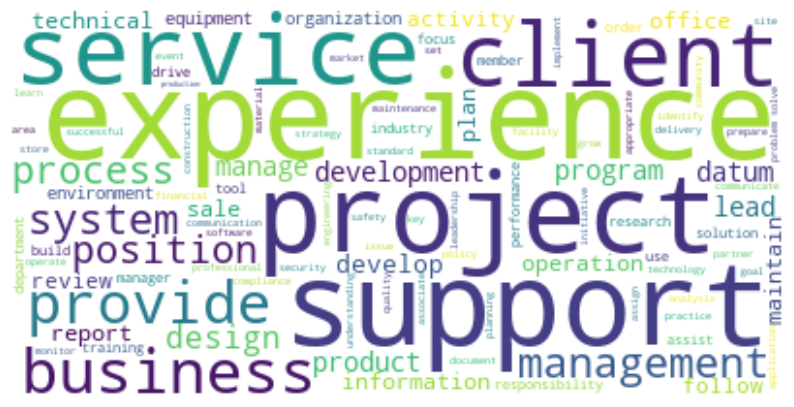

In [33]:
num_clusters = max(jobs_df['combined_cluster']) + 1

for cluster in range(num_clusters):
    text = " ".join(jobs_df[jobs_df['combined_cluster'] == cluster]['processed_description'].values)
    wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(text)
    print("\n*** Cluster", cluster, "***\n")

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Calculate silhouette values for combined job vectors and identify outliers with low silhouette scores

In [35]:
silhouette_vals = silhouette_samples(combined_vectors, cluster_labels)
outlier_threshold = 0.1
outliers = np.where(silhouette_vals < outlier_threshold)[0]

cleaned_df = jobs_df.drop(jobs_df.index[outliers])


for cluster in range(num_clusters):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == cluster]
    print(f"Cluster {cluster} - Average Silhouette Score: {np.mean(cluster_silhouette_vals)}")
    print('')
    
    if np.mean(cluster_silhouette_vals) < outlier_threshold:
        pass

for cluster in range(num_clusters):
    print(f"Cluster {cluster} descriptions:")
    sample_descriptions = jobs_df[jobs_df['combined_cluster'] == cluster]['processed_description'].sample(3)
    print(sample_descriptions)
    print('')

Cluster 0 - Average Silhouette Score: 0.15916526039165066

Cluster 1 - Average Silhouette Score: 0.0771028445744966

Cluster 0 descriptions:
240     ontarioposition permanent timethe food nutriti...
2913    minimum qualification non competitive minimum ...
1096    174410company healthlocation central zone memo...
Name: processed_description, dtype: object

Cluster 1 descriptions:
3735    position overview orbital welder support produ...
2468    talascend forklift heavy machine operator cont...
785     passionate cybersecurity want key player prote...
Name: processed_description, dtype: object



### define 'resume_to_vector' function to convert a preprocessed resume text into a combined vector representation using both the job description and title Word2Vec models, as well as the phrase models for descriptions and titles

In [52]:
def resume_to_vector(resume_text, word2vec_description_model, word2vec_title_model, descriptions_phrases, titles_phrases):
    resume_text_with_phrases = descriptions_phrases[titles_phrases[resume_text.split()]]
    resume_text_with_phrases = " ".join(resume_text_with_phrases)
    words = resume_text_with_phrases.split()
    description_word_vectors = []
    title_word_vectors = []

    for word in words:
        if word in word2vec_description_model.wv:
            description_word_vectors.append(word2vec_description_model.wv[word])
        if word in word2vec_title_model.wv:
            title_word_vectors.append(word2vec_title_model.wv[word])

    if description_word_vectors:
        description_vector = np.mean(description_word_vectors, axis=0)
    else:
        description_vector = np.zeros(word2vec_description_model.vector_size)

    if title_word_vectors:
        title_vector = np.mean(title_word_vectors, axis=0)
    else:
        title_vector = np.zeros(word2vec_title_model.vector_size)

    resume_vector = np.concatenate((description_vector, title_vector))

    return resume_vector




preprocessed_resume = preprocess_text(resume_text)
resume_vector = resume_to_vector(preprocessed_resume, word2vec_description_model,word2vec_title_model,descriptions_phrases,titles_phrases)

### Define 'match_resume_to_jobs' function to match a resume to job descriptions and titles based on their combined vector representations

In [53]:
def match_resume_to_jobs(resume_vector, combined_clusters, combined_vectors, top_n_clusters, top_n_jobs=3):
    all_job_similarities = cosine_similarity(resume_vector.reshape(1, -1), combined_vectors)
    ranked_jobs = []
    for cluster_label in np.unique(combined_clusters):
        job_indices_in_cluster = np.where(combined_clusters == cluster_label)[0]
        ranked_indices = all_job_similarities[:, job_indices_in_cluster].argsort()[0][-top_n_jobs:]
        ranked_jobs.extend(job_indices_in_cluster[ranked_indices])

    ranked_jobs = sorted(ranked_jobs, key=lambda x: all_job_similarities[0, x], reverse=True)

    return ranked_jobs[:top_n_clusters * top_n_jobs]





# top_n_jobs = 5
top_n_clusters = 1
top_job_indices = match_resume_to_jobs(resume_vector, combined_clusters, combined_vectors, top_n_clusters)


 ## Top matching jobs details

In [56]:
for job_index in top_job_indices:
    print(' Job Title: ',jobs_df.iloc[job_index]['Title'],'\n','Job Description: ',jobs_df.iloc[job_index]['Description'][0:40],'...','\n','Job Link: ',jobs_df.iloc[job_index]['Link'])
    print('')
   


 Job Title:  Data Engineer 
 Job Description:  OverviewAre you passionate about creatin ... 
 Job Link:  https://www.careerjet.ca/jobad/cad9c4b5420293ab2349042e83e10f1f45

 Job Title:  Data Governance Analyst 
 Job Description:  At the University of Guelph, fostering a ... 
 Job Link:  https://www.careerjet.ca/jobad/ca3606c164c62fe24445c76afa9a459512

 Job Title:  Analyst 
 Job Description:  Charger Logistics is a world class asset ... 
 Job Link:  https://www.careerjet.ca/jobad/caa2ee823d7e7a297f1f98277cc8ae84f5

